In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
import pandas as pd
import seaborn as sns

df = (
    pd.concat([
        pd.read_pickle('models/confusion-matrix-baseline.pkl'), 
        pd.read_pickle('models/confusion-matrix-random-forest.pkl'), 
        pd.read_pickle('models/confusion-matrix-fair-random-forest.pkl')
    ])
    .replace({'True': {'Compliant': 'C', 'Non-compliant': 'NC'}, 'Predicted': {'Non-compliant': 'NC', 'Compliant': 'C'}})
    .rename(columns={'True': 'Ground truth'})
)

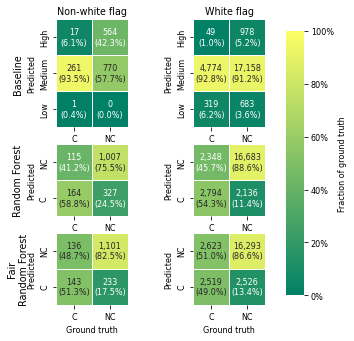

In [4]:
models = ('Baseline', 'Random Forest', 'Fair Random Forest')
flags = ('Non-white', 'White')
three_cat_labels = ['High', 'Medium', 'Low']
two_cat_labels = ['C', 'NC']
with plt.rc_context({'font.size': 8}):
    fig, axs = plt.subplots(len(models),len(flags), figsize=(4.82,5.25), gridspec_kw={'height_ratios': [3,2,2], 'right': .85})
    cbar_ax = fig.add_axes([.85, .15, .05, .7])

    for row_idx, row in enumerate(models):
        for col_idx, col in enumerate(flags):
            ax = axs[row_idx,col_idx]
            if row == 'Baseline':
                data = df.loc[lambda x: (x['Model'] == row) & (x['Flag'] == col)].pivot('Predicted', 'Ground truth', 'Number').loc[three_cat_labels, two_cat_labels]
            else:
                data = df.loc[lambda x: (x['Model'] == row) & (x['Flag'] == col)].pivot('Predicted', 'Ground truth', 'Number').loc[two_cat_labels[::-1], two_cat_labels]
            fractions = (data / data.sum(0)).round(3)
            if row == 'Baseline':
                annot = np.array([[f'{data.iloc[i,j]:,}\n({fractions.iloc[i,j]:.1%})' for j in (0,1)] for i in (0,1,2)])
            else:
                annot = np.array([[f'{data.iloc[i,j]:,}\n({fractions.iloc[i,j]:.1%})' for j in (0,1)] for i in (0,1)])
            
            cbar = ((row_idx == 0) and (col_idx == 0))
            cbar_kws = {'label': 'Fraction of ground truth', 'format': PercentFormatter()}
            sns.heatmap(data=100*fractions, ax=ax, annot=annot, cmap='summer', fmt='', square=True, linewidth=.5, cbar=cbar, cbar_ax=cbar_ax, cbar_kws=cbar_kws, vmin=0, vmax=100)
            if row_idx == 0:
                ax.annotate(f"{col} flag", xy=(.5, 1), xytext=(0, 5), xycoords='axes fraction', textcoords='offset points', ha='center', va='baseline', size='large')
            if col_idx == 0:
                if row == "Fair Random Forest":
                    ax.annotate("Fair\nRandom Forest", xy=(0, .5), xytext=(-ax.yaxis.labelpad - 5, 0), xycoords=ax.yaxis.label, textcoords='offset points', size='large', ha='center', va='center', rotation=90)
                elif row == "Random Forest":
                    ax.annotate("Random Forest", xy=(0, .5), xytext=(-ax.yaxis.labelpad - 5, 0), xycoords=ax.yaxis.label, textcoords='offset points', size='large', ha='center', va='center', rotation=90)
                elif row == "Baseline":
                    ax.annotate("Baseline", xy=(0, .5), xytext=(-ax.yaxis.labelpad - 5, 0), xycoords=ax.yaxis.label, textcoords='offset points', size='large', ha='center', va='center', rotation=90)

    # fig.subplots_adjust(hspace=.5, wspace=.1)
    plt.savefig('fig/confusion_matrix.pdf', bbox_inches='tight')